In [0]:
%matplotlib inline

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.datasets import cifar10
from keras.layers import Dropout, Input, Activation
from keras.layers import Conv2D, GlobalAvgPool2D, MaxPool2D, UpSampling2D
from keras.models import Model
from keras.optimizers import RMSprop 
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.utils import to_categorical
from keras import models
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

np.random.seed(123)

## Data preparation

In [0]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [72]:
print("Training set has shape {}".format(x_train.shape))
print("Testing set has shape {}".format(x_test.shape))

Training set has shape (50000, 32, 32, 3)
Testing set has shape (10000, 32, 32, 3)


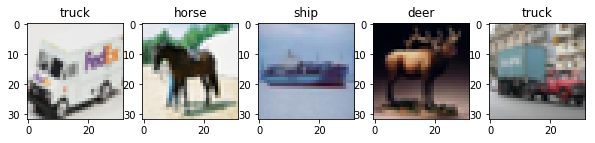

In [73]:
classes = ("airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")
random_img = np.random.randint(0, len(x_train), 5)
fig, ax = plt.subplots(1, 5, figsize = (10,5))
for i, ind in enumerate(random_img):
    ax[i].imshow(x_train[ind])
    ax[i].set_title(classes[y_train[ind][0]])

In [0]:
# Keep 50% of bird, deer and truck classes
bird_idx = np.where(y_train == 2)[0]
deer_idx = np.where(y_train == 4)[0]
truck_idx = np.where(y_train == 9)[0]

bird_idx_sample = list(np.random.choice(bird_idx, size=2500, replace=False))
deer_idx_sample = list(np.random.choice(deer_idx, size=2500, replace=False))
truck_idx_sample = list(np.random.choice(truck_idx, size=2500, replace=False))

idx_sample = bird_idx_sample + deer_idx_sample + truck_idx_sample

x_train = np.delete(x_train, idx_sample, axis=0)
y_train = np.delete(y_train, idx_sample, axis=0)

In [75]:
print("Training set has shape {}".format(x_train.shape))
print("Validation set has shape {}".format(x_test.shape))
print("Labels set has shape {}".format(y_train.shape))

Training set has shape (42500, 32, 32, 3)
Validation set has shape (10000, 32, 32, 3)
Labels set has shape (42500, 1)


### Balance data

In [0]:
def random_rotation(image):
    from skimage import transform
    random_degree = np.random.uniform(-10, 10)
    return transform.rotate(image, random_degree)

def random_shift(image):
    from scipy.ndimage import shift
    h_shift = np.random.uniform(-4, 4)
    w_shift = np.random.uniform(-4, 4)
    return shift(image, [h_shift, w_shift, 0])

def horizontal_flip(image):
    return np.fliplr(image)

In [77]:
# the images and labels from the bird, deer and truck class 
x_lost = x_train[np.isin(y_train.T[0], [2, 4, 9])]
y_lost = y_train[np.isin(y_train.T[0], [2, 4, 9])]
print("Training set has shape {}".format(x_lost.shape))
print("Labels set has shape {}".format(y_lost.shape))

Training set has shape (7500, 32, 32, 3)
Labels set has shape (7500, 1)


In [0]:
# Data augmentation on lost data to balance classes
def transform_randomly(img):
    transformed_img = np.copy(img)
    random_choice = np.random.uniform(size=3)
    if random_choice[0] > 0.5:
        transformed_img = random_rotation(img)
    if random_choice[1] > 0.5:
        transformed_img = random_shift(img)
    if random_choice[2] > 0.5:
        transformed_img = horizontal_flip(img)
    return transformed_img
    
x_add = np.array([transform_randomly(img) for img in x_lost])
y_add = np.array([label for label in y_lost])

In [0]:
# add created data to original data
x_train = np.r_[x_train, x_add]
y_train = np.r_[y_train, y_add]

In [80]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 5000,
 1: 5000,
 2: 5000,
 3: 5000,
 4: 5000,
 5: 5000,
 6: 5000,
 7: 5000,
 8: 5000,
 9: 5000}

### Split data

In [0]:
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
x_train = x_train.astype("float32")/255.0
x_test = x_test.astype("float32")/255.0

In [0]:
x_tr, x_val, y_tr, y_val = train_test_split(x_train,
                                            y_train,
                                            test_size=0.2,
                                            random_state=123,
                                            stratify=y_train)

## Train

### Train autoencoder

In [0]:
def encoder(inputs):
    x = Conv2D(96, 3, activation="relu", padding="same")(inputs)
    x = Conv2D(96, 3, activation="relu", padding="same")(x)
    x = MaxPool2D(3, strides=2)(x)
    x = Dropout(0.5)(x)

    x = Conv2D(192, 3, activation="relu", padding="same")(x)
    x = Conv2D(192, 3, activation="relu", padding="same")(x)
    x = MaxPool2D(3, strides=2)(x)
    x = Dropout(0.5)(x)

    return x

def decoder(inputs):
    x = Conv2D(192, 3, activation="relu", padding="same")(inputs)
    x = Conv2D(192, 3, activation="relu", padding="same")(x)
    x = UpSampling2D(3)(x)
    x = Dropout(0.5)(x)

    x = Conv2D(96, 3, activation="relu")(x)
    x = Conv2D(96, 3, activation="relu")(x)
    x = UpSampling2D(2)(x)
    x = Dropout(0.5)(x)

    x = Conv2D(3, 3, activation="sigmoid", name="autoencoder")(x)
    return x

def auto_encoder(inputs):
    x = encoder(inputs)
    x = decoder(x)
    return x

In [0]:
inputs = Input(shape=(32, 32, 3))
autoencoder = Model(inputs, outputs=auto_encoder(inputs))

In [0]:
model_check = ModelCheckpoint("autoencoder.h5",
                              monitor='val_loss',
                              verbose=0,
                              save_best_only=True,
                              save_weights_only=False)
autoencoder.compile(optimizer="rmsprop", loss="mse")
autoencoder.fit(x_tr,
                x_tr,
                batch_size=batch_size,
                epochs=100,
                validation_data=(x_val, x_val),
                callbacks=[model_check])

Train on 34000 samples, validate on 8500 samples
Epoch 1/100
34000/34000 [==============================] - 28s 819us/step - loss: 0.0176 - val_loss: 0.0090
Epoch 2/100
34000/34000 [==============================] - 21s 619us/step - loss: 0.0086 - val_loss: 0.0066
Epoch 3/100
34000/34000 [==============================] - 21s 616us/step - loss: 0.0073 - val_loss: 0.0058
Epoch 4/100
34000/34000 [==============================] - 21s 613us/step - loss: 0.0066 - val_loss: 0.0053
Epoch 5/100
34000/34000 [==============================] - 21s 613us/step - loss: 0.0062 - val_loss: 0.0052
Epoch 6/100
34000/34000 [==============================] - 21s 615us/step - loss: 0.0059 - val_loss: 0.0046
Epoch 7/100
34000/34000 [==============================] - 21s 616us/step - loss: 0.0056 - val_loss: 0.0044
Epoch 8/100
34000/34000 [==============================] - 21s 614us/step - loss: 0.0054 - val_loss: 0.0049
Epoch 9/100
34000/34000 [==============================] - 21s 612us/step - loss: 0.005

### Train Classifier

In [0]:
def mini_cnn(inputs):
    x = Conv2D(192, 3, activation="relu", padding="same", kernel_regularizer=l2())(inputs)
    x = Conv2D(192, 1, activation="relu", padding="same", kernel_regularizer=l2())(x)
    x = Conv2D(10, 1, activation="relu", padding="same", kernel_regularizer=l2())(x)
    x = Dropout(0.5)(x)
    x = GlobalAvgPool2D()(x)
    x = Activation("softmax", name="classifier_out")(x)
    return x

In [0]:
inputs = Input(shape=(32, 32, 3))
encoded_inputs = encoder(inputs)

classifier = Model(inputs, 
                   outputs=[decoder(encoded_inputs), mini_cnn(encoded_inputs)])

In [0]:
# Data augmentation
datagen = ImageDataGenerator(rotation_range=10,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             fill_mode='nearest',
                             horizontal_flip=True)
y_valids = {
          "autoencoder": x_val,
          "classifier_out": y_val}

def data_generator(x, y, batch_size):
    for x_batch, y_batch in datagen.flow(x, y, batch_size):
        yield (x_batch, {"autoencoder": x_batch, "classifier_out": y_batch})
        
# Callbacks
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 50:
        lrate = lrate * 0.1
    if epoch > 75:
        lrate = lrate * 0.5
    if epoch > 100:
        lrate = lrate * 0.2
    return lrate

callbacks = [
    LearningRateScheduler(lr_schedule),
    ModelCheckpoint("ep{epoch:02d}-acc{classifier_out_acc:.2f}.h5", 
                    verbose=0, save_best_only=True, save_weights_only=False)
]

In [0]:
# initialize with autoencoder trained models
for clf_w, autoenc_w in zip(classifier.layers[:9], autoencoder.layers[:9]):
    clf_w.set_weights(autoenc_w.get_weights())

classifier.compile(
    optimizer=RMSprop(lr=1e-3, decay=1e-6), 
    loss={"autoencoder": "mse", "classifier_out": "categorical_crossentropy"}, 
    loss_weights={"autoencoder": 1.0, "classifier_out": 2.0}, 
    metrics={"classifier_out": "accuracy"}
)

In [0]:
batch_size = 64
epochs = 125

classifier_history = classifier.fit_generator(
    data_generator(x_tr, y_tr, batch_size),
    steps_per_epoch=len(x_tr)//batch_size,     
    epochs=epochs,
    validation_data=(x_val, y_valids),
    callbacks=callbacks)

Epoch 1/125
625/625 [==============================] - 66s 105ms/step - loss: 1.5652 - autoencoder_loss: 0.0191 - classifier_out_loss: 0.7150 - classifier_out_acc: 0.7635 - val_loss: 1.2039 - val_autoencoder_loss: 0.0194 - val_classifier_out_loss: 0.5305 - val_classifier_out_acc: 0.8329
Epoch 2/125
625/625 [==============================] - 64s 102ms/step - loss: 1.5208 - autoencoder_loss: 0.0193 - classifier_out_loss: 0.6870 - classifier_out_acc: 0.7743 - val_loss: 1.1406 - val_autoencoder_loss: 0.0196 - val_classifier_out_loss: 0.4963 - val_classifier_out_acc: 0.8408
Epoch 3/125
625/625 [==============================] - 64s 102ms/step - loss: 1.5226 - autoencoder_loss: 0.0194 - classifier_out_loss: 0.6864 - classifier_out_acc: 0.7745 - val_loss: 1.3232 - val_autoencoder_loss: 0.0196 - val_classifier_out_loss: 0.5863 - val_classifier_out_acc: 0.8064
Epoch 4/125
625/625 [==============================] - 64s 102ms/step - loss: 1.5052 - autoencoder_loss: 0.0194 - classifier_out_loss: 0

### Results

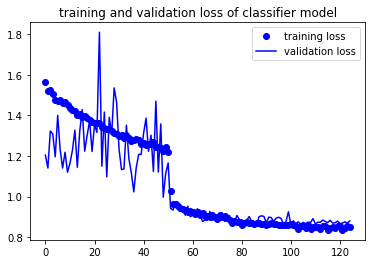

In [0]:
train_loss = classifier_history.history["loss"]
val_loss = classifier_history.history["val_loss"]
steps = range(len(train_loss))

plt.plot(steps, train_loss, 'bo',label="training loss")
plt.plot(steps, val_loss, 'b',label = "validation loss")
plt.legend(loc="best")
plt.title("training and validation loss of classifier model")
plt.show()

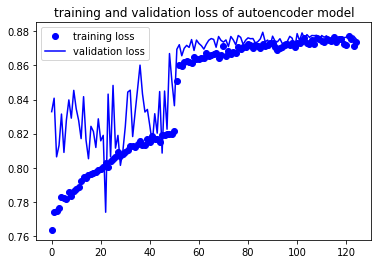

In [0]:
train_loss = classifier_history.history["classifier_out_acc"]
val_loss = classifier_history.history["val_classifier_out_acc"]
steps = range(len(train_loss))

plt.plot(steps, train_loss, 'bo',label="training loss")
plt.plot(steps, val_loss, 'b',label = "validation loss")
plt.legend(loc="best")
plt.title("training and validation loss of autoencoder model")
plt.show()

In [0]:
# function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    This function is from sklean website"""
    
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(13, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


In [0]:
_, y_pred = classifier.predict(x_val)
y_true = np.argmax(y_val, axis=1)
y_pred = np.argmax(y_pred, axis=1)

Normalized confusion matrix
[[0.874 0.007 0.026 0.002 0.006 0.007 0.014 0.021 0.018 0.025]
 [0.006 0.917 0.003 0.003 0.    0.002 0.007 0.    0.007 0.055]
 [0.024 0.001 0.837 0.003 0.016 0.047 0.056 0.01  0.001 0.005]
 [0.015 0.004 0.026 0.605 0.015 0.163 0.112 0.029 0.011 0.02 ]
 [0.011 0.    0.052 0.006 0.812 0.019 0.05  0.046 0.    0.004]
 [0.004 0.001 0.009 0.044 0.012 0.841 0.045 0.036 0.004 0.004]
 [0.004 0.001 0.016 0.008 0.005 0.008 0.95  0.003 0.    0.005]
 [0.01  0.    0.005 0.012 0.008 0.052 0.009 0.894 0.003 0.007]
 [0.057 0.02  0.007 0.001 0.001 0.001 0.006 0.005 0.871 0.031]
 [0.004 0.01  0.003 0.001 0.002 0.002 0.005 0.005 0.002 0.966]]


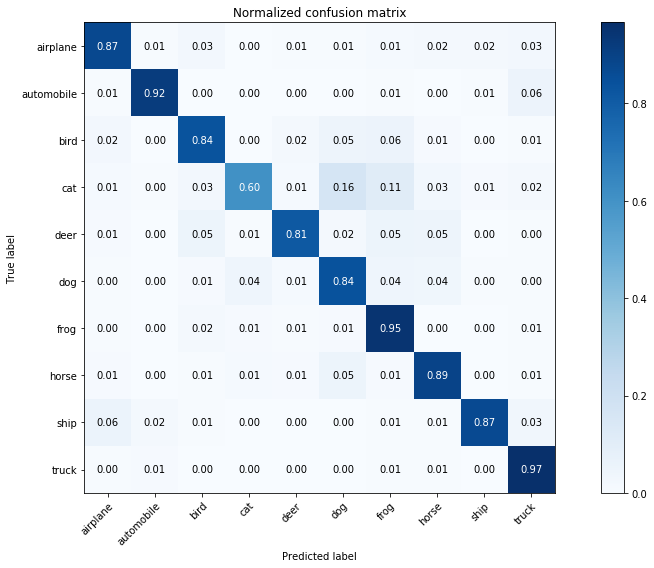

In [0]:
plot_confusion_matrix(y_true, y_pred, classes=np.array(classes), normalize=True,
                      title='Normalized confusion matrix')

## Test

Before using our final model to predict testing data labels, we will train it on whole training data + validation data.<br>
in the previous model, the accuracy stagnate at epoch 100.
So we will train the model for only 100 epochs instead of 125.

In [0]:
model_check = ModelCheckpoint("model.h5", 
                              monitor='classifier_out_acc', 
                              verbose=0, 
                              save_best_only=True, 
                              save_weights_only=False)

In [0]:
classifier_history = classifier.fit_generator(
          data_generator(x_train, y_train, batch_size),
          steps_per_epoch=len(x_train)//batch_size,     
          epochs=100,
          callbacks=[model_check, LearningRateScheduler(lr_schedule)])

Epoch 1/100
665/664 [==============================] - 65s 98ms/step - loss: 1.2186 - autoencoder_loss: 0.0210 - classifier_out_loss: 0.5455 - classifier_out_acc: 0.8224
Epoch 2/100
665/664 [==============================] - 65s 98ms/step - loss: 1.2163 - autoencoder_loss: 0.0209 - classifier_out_loss: 0.5440 - classifier_out_acc: 0.8249
Epoch 3/100
665/664 [==============================] - 65s 98ms/step - loss: 1.2169 - autoencoder_loss: 0.0210 - classifier_out_loss: 0.5442 - classifier_out_acc: 0.8231
Epoch 4/100
665/664 [==============================] - 65s 98ms/step - loss: 1.2039 - autoencoder_loss: 0.0210 - classifier_out_loss: 0.5375 - classifier_out_acc: 0.8228
Epoch 5/100
665/664 [==============================] - 65s 98ms/step - loss: 1.2112 - autoencoder_loss: 0.0209 - classifier_out_loss: 0.5417 - classifier_out_acc: 0.8220
Epoch 6/100
665/664 [==============================] - 65s 97ms/step - loss: 1.2078 - autoencoder_loss: 0.0209 - classifier_out_loss: 0.5399 - classif

In [0]:
y_tests = {
        "autoencoder": x_test,
        "classifier_out": y_test}
score = final_model.evaluate(x_test, y_tests)
print("test accuracy : {0:.2f}".format(score[3]*100))

10000/10000 [==============================] - 6s 567us/step
test accuracy : 85.41


Normalized confusion matrix
[[0.936 0.009 0.009 0.001 0.003 0.001 0.009 0.006 0.017 0.009]
 [0.001 0.988 0.    0.    0.    0.    0.004 0.    0.002 0.005]
 [0.018 0.001 0.888 0.003 0.014 0.011 0.044 0.013 0.003 0.005]
 [0.011 0.009 0.009 0.763 0.021 0.067 0.078 0.027 0.01  0.005]
 [0.005 0.    0.011 0.003 0.911 0.007 0.042 0.02  0.    0.001]
 [0.004 0.003 0.007 0.044 0.012 0.844 0.046 0.034 0.004 0.002]
 [0.006 0.    0.004 0.003 0.002 0.001 0.982 0.001 0.001 0.   ]
 [0.005 0.001 0.003 0.01  0.006 0.02  0.011 0.939 0.003 0.002]
 [0.016 0.01  0.002 0.001 0.001 0.    0.002 0.002 0.961 0.005]
 [0.005 0.02  0.002 0.    0.    0.    0.004 0.001 0.002 0.966]]


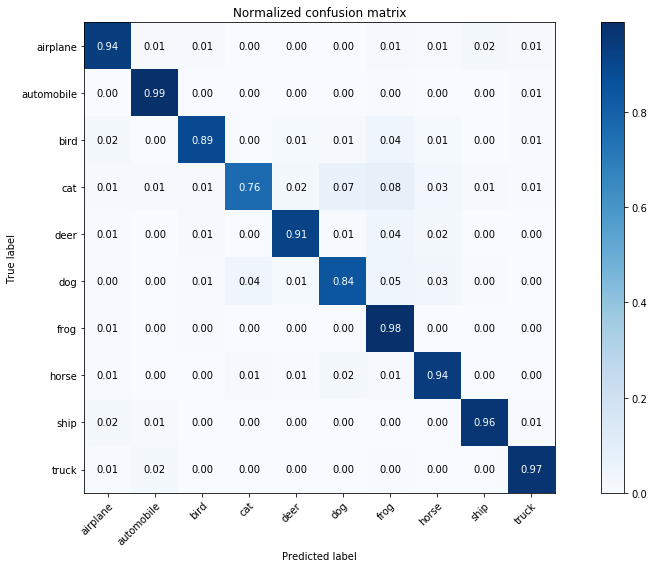

In [0]:
_, y_pred = classifier.predict(y_test)
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)
plot_confusion_matrix(y_true, y_pred, classes=np.array(classes), normalize=True,
                      title='Normalized confusion matrix')